In [2]:
import os
import json
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

In [3]:
cd ../../experiment-scripts/

/Users/bittner/Dropbox/MARL/repos/aes-semantic-audio-2016/experiment-scripts


In [4]:
import utils

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
# OUTPUT_DIR = '../output/gt_experiment_noavgpitch/'
EXP_DIR = '../output/gt_experiment_extratasks/'
EXP_DIR_NOPITCH = '../output/gt_experiment_noavgpitch/'
OUTPUT_DIR = EXP_DIR
NSPLITS = 5
FEATURE_NAMES = utils.FTR.feature_names

In [52]:
def load_classifier(split_num, task, nopitch):
    if nopitch:
        path = os.path.join(
            EXP_DIR_NOPITCH, "split-{}".format(split_num), "{}_classifier.pkl".format(task)
        )    
    else:
        path = os.path.join(
            OUTPUT_DIR, "split-{}".format(split_num), "{}_classifier.pkl".format(task)
        )
    clf = utils.load_classifier(path)
    return clf

def load_labels(split_num, task):
    path = os.path.join(
        OUTPUT_DIR, "split-{}".format(split_num), "{}_labels.json".format(task)
    )
    with open(path, 'r') as fhandle:
        data = json.load(fhandle)
    return data['labels']

def load_scores(split_num, task, nopitch):
    if nopitch:
        path = os.path.join(
            EXP_DIR_NOPITCH, "split-{}".format(split_num), "{}_scores.json".format(task)
        )
    else:
        path = os.path.join(
            OUTPUT_DIR, "split-{}".format(split_num), "{}_scores.json".format(task)
        )
    with open(path, 'r') as fhandle:
        scores = json.load(fhandle)
    return scores

In [7]:
scores = load_scores(0, 'vocal')
clf = load_classifier(0, 'vocal')
class_labels = load_labels(0, 'vocal')
print(scores)

{u'test': {u'f1': [0.7608254036138137, 0.7284205414592692], u'recall': [0.7228034535297105, 0.7746933505487411], u'support': [9845, 7745], u'mcc': 0.4939525723478364, u'precision': [0.8030696309671594, 0.6873639592164051], u'auc score': 0.8282940188807735, u'confusion matrix': [[7116, 2729], [1745, 6000]], u'accuracy': 0.7456509380329733}, u'train': {u'f1': [1.0, 1.0], u'recall': [1.0, 1.0], u'support': [46800, 44904], u'mcc': 1.0, u'precision': [1.0, 1.0], u'auc score': 1.0, u'confusion matrix': [[46800, 0], [0, 44904]], u'accuracy': 1.0}}


In [28]:
def get_score_statistics(task, statistic, nopitch=False):
    score_values = []
    for i in range(NSPLITS):
        scores = load_scores(i, task, nopitch)
        score_values.append(scores['test'][statistic])
    return np.mean(score_values), np.std(score_values)

In [51]:
def get_average_feature_importances(task, nopitch=False):
    all_importances = []
    for i in range(NSPLITS):
        clf = load_classifier(i, task, nopitch)
        all_importances.append(clf.clf.feature_importances_)
    all_importances = np.array(all_importances)
    return np.mean(all_importances, axis=0), np.std(all_importances, axis=0)

In [72]:
def get_average_confusion_matrix(task, nopitch=False):
    all_matrices = []
    for i in range(NSPLITS):
        scores = load_scores(i, task, nopitch=nopitch)
        confusion_matrix = np.array(scores['test']['confusion matrix'], dtype=float)
        row_sum = np.sum(confusion_matrix, axis=1)
        row_sum[row_sum == 0] = 1.0
        confusion_matrix_norm = (confusion_matrix.T / row_sum).T
        all_matrices.append(confusion_matrix_norm)
    
    all_matrices = np.mean(all_matrices, axis=0)
    return all_matrices

In [49]:
def plot_feature_importances(importances):
    plt.figure(figsize=(12, 7))
    x = np.arange(len(importances))
    y = importances
    plt.bar(x, y)
    plt.xticks(x, FEATURE_NAMES, rotation='vertical')
    plt.show()

In [70]:
def plot_confusion_matrix(task):
    avg_matrix = get_average_confusion_matrix(task)
    labels = load_labels(0, task)

    plt.title('{} Confusion Matrix'.format(task))
    plt.imshow(avg_matrix, interpolation='nearest', cmap='cool')#, vmin=0, vmax=1)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.axis('auto')
    plt.axis('tight')
    
    n_x, n_y = avg_matrix.shape
    plt.xticks(range(n_x), labels, rotation='vertical')
    plt.yticks(range(n_y), labels, rotation='horizontal')
    plt.colorbar()

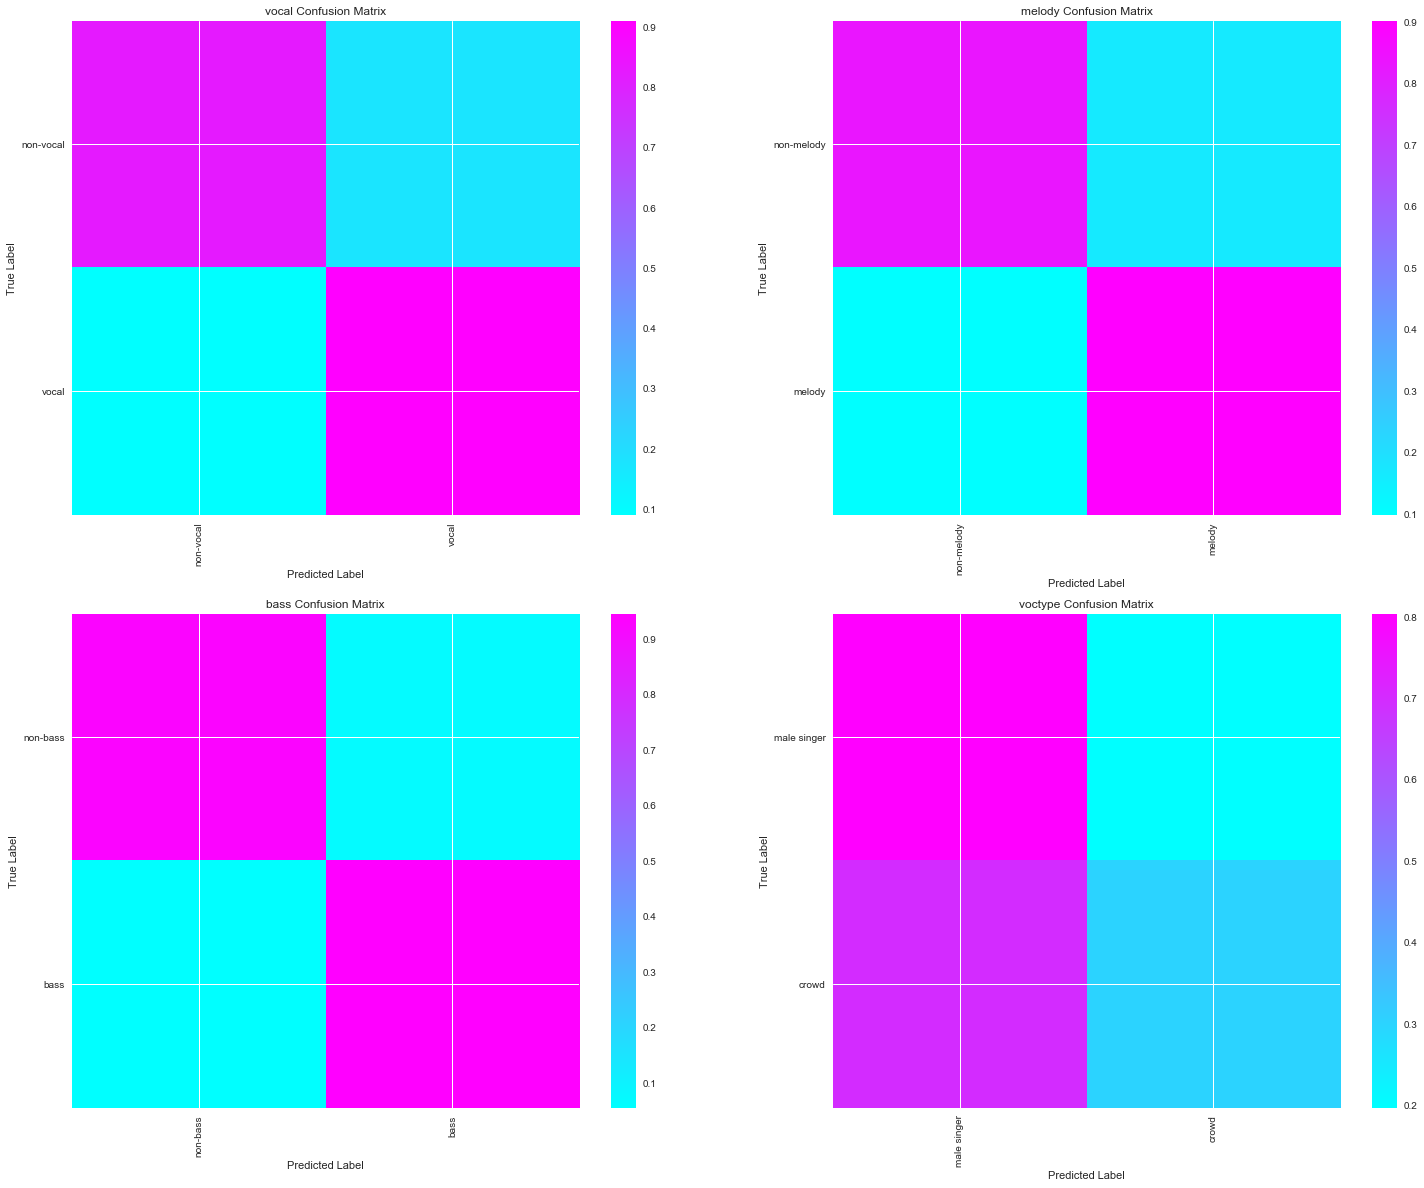

In [74]:
plt.figure(figsize=(25, 20))

plt.subplot(2, 2, 1)
plot_confusion_matrix('vocal')

plt.subplot(2, 2, 2)
plot_confusion_matrix('melody')

plt.subplot(2, 2, 3)
plot_confusion_matrix('bass')

plt.subplot(2, 2, 4)
plot_confusion_matrix('voctype')

plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.pdf'), format='pdf')

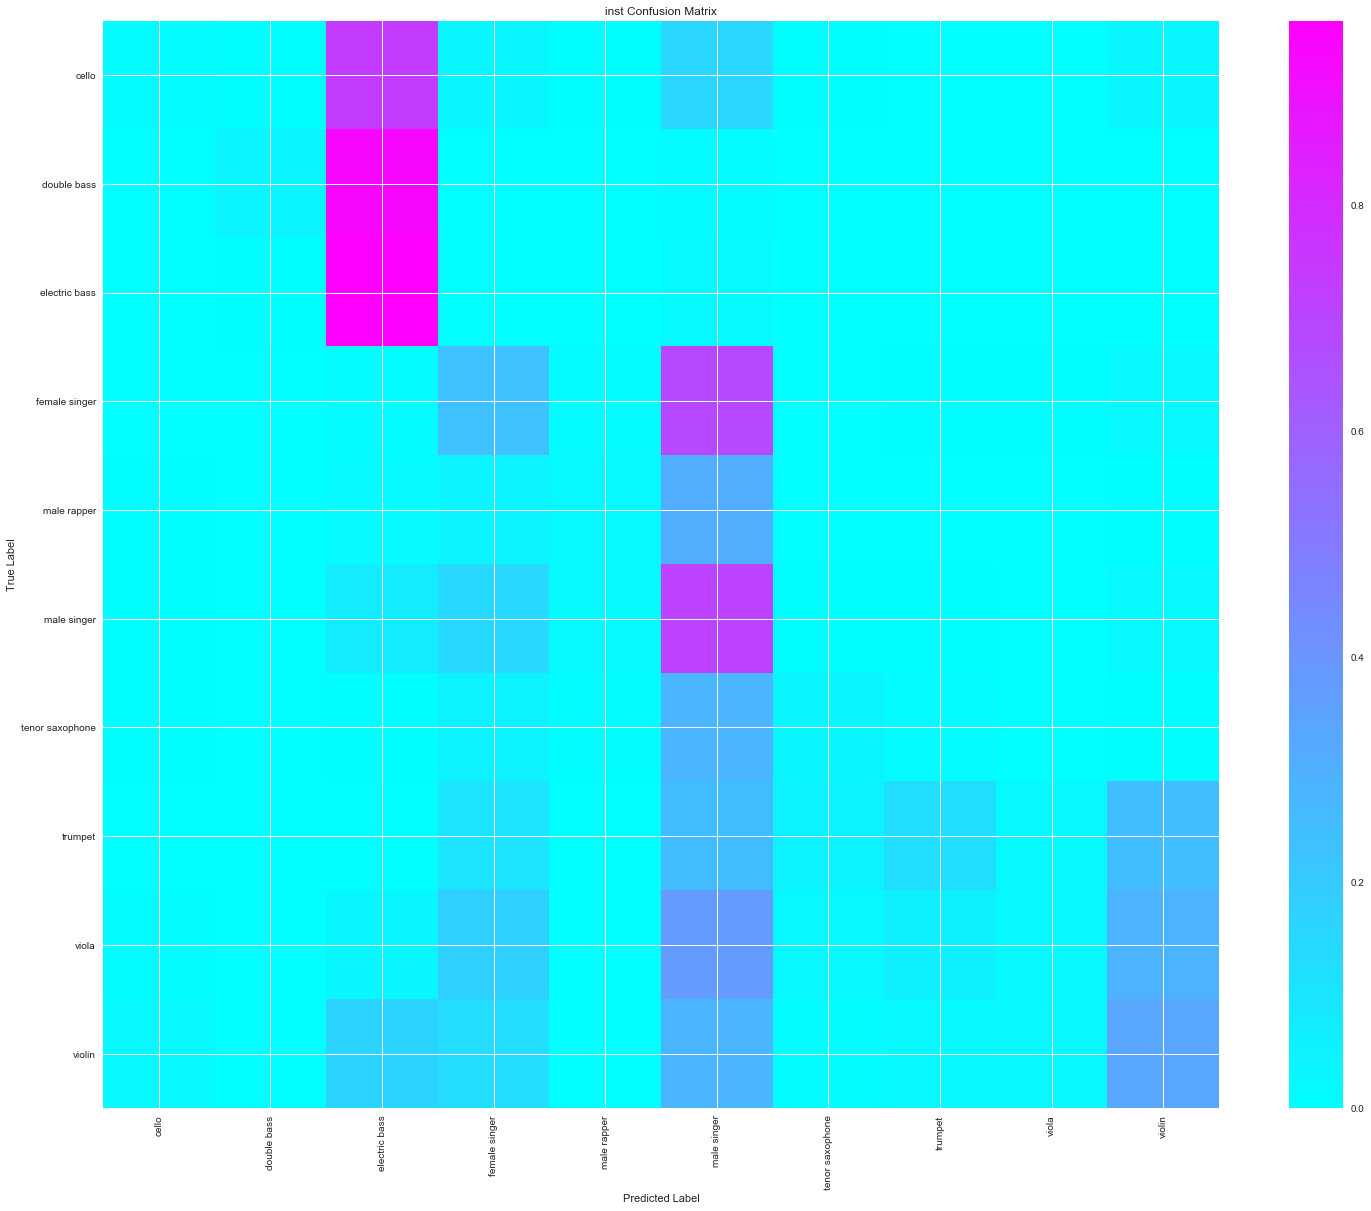

In [73]:
plt.figure(figsize=(25, 20))

plot_confusion_matrix('inst')


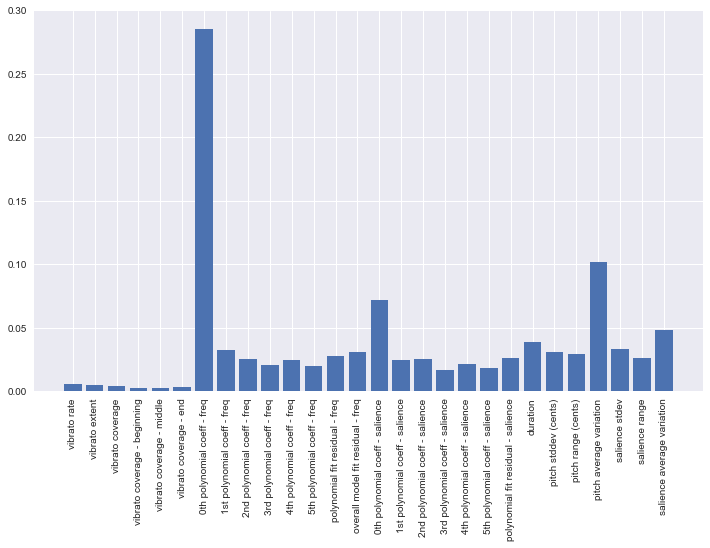

In [78]:
importances, _ = get_average_feature_importances('inst')
plot_feature_importances(importances)

### Plot feature importances matrix for all tasks

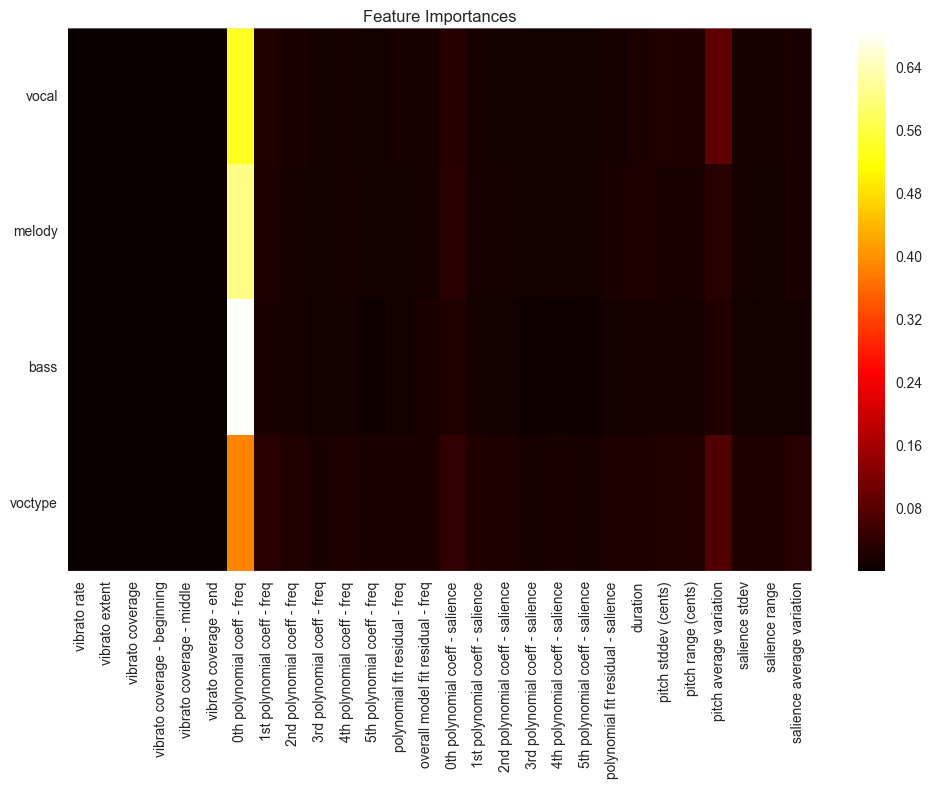

In [85]:
vocal_imps, vocal_std = get_average_feature_importances('vocal')
melody_imps, melody_std = get_average_feature_importances('melody')
bass_imps, bass_std = get_average_feature_importances('bass')
inst_imps, inst_std = get_average_feature_importances('voctype')

index = np.arange(len(FEATURE_NAMES))

all_task_imps = np.vstack([vocal_imps, melody_imps, bass_imps, inst_imps])

plt.figure(figsize=(12, 7))
plt.title('Feature Importances')
plt.imshow(all_task_imps, interpolation='none', cmap='hot')
plt.axis('auto')
plt.axis('tight')
plt.xticks(index, FEATURE_NAMES, rotation='vertical')
plt.yticks(range(4), ['vocal', 'melody', 'bass', 'voctype'], rotation='horizontal')
plt.colorbar()

plt.show()

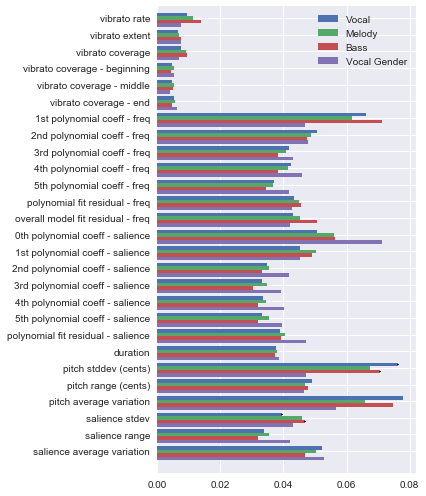

In [55]:
vocal_imps, vocal_std = get_average_feature_importances('vocal', nopitch=True)
melody_imps, melody_std = get_average_feature_importances('melody', nopitch=True)
bass_imps, bass_std = get_average_feature_importances('bass', nopitch=True)
inst_imps, inst_std = get_average_feature_importances('voctype', nopitch=True)

index = np.arange(len(FEATURE_NAMES) -1)

bar_width = 0.21
c1, c2, c3, c4 = sns.color_palette(n_colors=4)
n = 0

plt.figure(figsize=(6, 7))
# plt.title('Feature Importances')

rects1 = plt.barh(index[n:], vocal_imps[n:], bar_width,
                 color=c1,
                 yerr=vocal_std[n:],
                 label='Vocal')
rects2 = plt.barh(index[n:] + bar_width, melody_imps[n:], bar_width,
                 color=c2,
                 yerr=melody_std[n:],
                 label='Melody')
rects3 = plt.barh(index[n:] + 2.0*bar_width, bass_imps[n:], bar_width,
                 color=c3,
                 yerr=bass_std[n:],
                 label='Bass')
rects4 = plt.barh(index[n:] + 3.0*bar_width, inst_imps[n:], bar_width,
                 color=c4,
                 yerr=inst_std[n:],
                 label='Vocal Gender')
yticks = FEATURE_NAMES[n:]
yticks = FEATURE_NAMES[:6] + FEATURE_NAMES[7:]
plt.yticks(index + 0.2, yticks, rotation='horizontal')
plt.ylim([-0.5, 27.5])
# plt.xlim([0, 0.7])#0.095])

plt.gca().invert_yaxis()
plt.legend(loc=1)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importances.pdf'), format='pdf')

### Plot Accuracy for each task

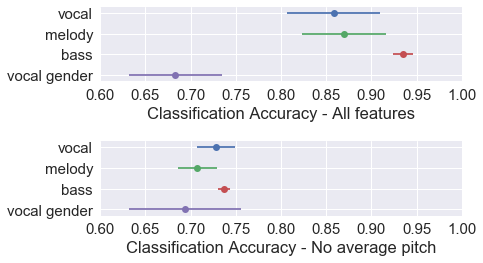

In [88]:
c1, c2, c3, c4 = sns.color_palette(n_colors=4)
error_config = {'ecolor': '0.3'}
min_x = 0.6

sns.set(font_scale=1.5)

plt.figure(figsize=(7, 4))

plt.subplot(2, 1, 1)

statistic = 'accuracy'
vocal_avg, vocal_std = get_score_statistics('vocal', statistic)
mel_avg, mel_std = get_score_statistics('melody', statistic)
bass_avg, bass_std = get_score_statistics('bass', statistic)
inst_avg, inst_std = get_score_statistics('voctype', statistic)

index = np.arange(4)
score_avg = [inst_avg, bass_avg, mel_avg, vocal_avg]
score_std = [inst_std, bass_std, mel_std, vocal_std]
rects1 = plt.errorbar(
    inst_avg, 0, color=c4, fmt='o', xerr=inst_std
)
rects2 = plt.errorbar(
    bass_avg, 1, color=c3, fmt='o', xerr=bass_std
)
rects3 = plt.errorbar(
    mel_avg, 2, color=c2, fmt='o', xerr=mel_std
)
rects4 = plt.errorbar(
    vocal_avg, 3, color=c1, fmt='o', xerr=vocal_std
)

ylab = ['vocal gender', 'bass', 'melody', 'vocal']
plt.yticks(index, ylab, rotation='horizontal')
plt.ylim([-0.3, 3.3])
plt.xlim([min_x, 1])
plt.xlabel('Classification Accuracy - All features')
plt.tight_layout()

plt.subplot(2, 1, 2)

statistic = 'accuracy'
vocal_avg, vocal_std = get_score_statistics('vocal', statistic, nopitch=True)
mel_avg, mel_std = get_score_statistics('melody', statistic, nopitch=True)
bass_avg, bass_std = get_score_statistics('bass', statistic, nopitch=True)
inst_avg, inst_std = get_score_statistics('voctype', statistic, nopitch=True)

index = np.arange(4)
# score_avg = [vocal_avg, mel_avg, bass_avg, inst_avg]
# score_std = [vocal_std, mel_std, bass_std, inst_std]
score_avg = [inst_avg, bass_avg, mel_avg, vocal_avg]
score_std = [inst_std, bass_std, mel_std, vocal_std]
rects1 = plt.errorbar(
    inst_avg, 0, color=c4, fmt='o', xerr=inst_std
)
rects2 = plt.errorbar(
    bass_avg, 1, color=c3, fmt='o', xerr=bass_std
)
rects3 = plt.errorbar(
    mel_avg, 2, color=c2, fmt='o', xerr=mel_std
)
rects4 = plt.errorbar(
    vocal_avg, 3, color=c1, fmt='o', xerr=vocal_std
)

ylab = ['vocal gender', 'bass', 'melody', 'vocal']
plt.yticks(index, ylab, rotation='horizontal')
plt.ylim([-0.3, 3.3])
plt.xlim([min_x, 1])
plt.xlabel('Classification Accuracy - No average pitch')
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_DIR, 'task_accuracy.pdf'), format='pdf')